In [181]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmedmohamed2003/cafe-sales-dirty-data-for-cleaning-training")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cafe-sales-dirty-data-for-cleaning-training


In [182]:
import pandas as pd
import os

# List files in the downloaded directory to find the CSV file
file_list = os.listdir(path)
print("Files in the downloaded directory:", file_list)

# Assuming the CSV file is the first file in the directory, or you know its name
# You might need to adjust the filename based on the output of listdir
csv_file_path = os.path.join(path, file_list[0])

df = pd.read_csv(csv_file_path)
df.head()

Files in the downloaded directory: ['dirty_cafe_sales.csv']


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


Import required Dependencies

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

In [184]:
# Get to understand data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


We have 1000 data entries (rows) and 8 columns. As we can see the data is messy. All data types are labeled as object.

## Data cleaning step by step

In [185]:
# Replace gaps in columns and Capitalize first letter
df.columns = df.columns.str.replace(' ', '_').str.capitalize()

In [186]:
# check the columns
df.columns

Index(['Transaction_id', 'Item', 'Quantity', 'Price_per_unit', 'Total_spent',
       'Payment_method', 'Location', 'Transaction_date'],
      dtype='object')

In [187]:
# change the data types of numeric columns and date
df['Quantity'] = pd.to_numeric(df['Quantity'], errors = 'coerce')

df['Price_per_unit'] = pd.to_numeric(df['Price_per_unit'], errors = 'coerce')

df['Total_spent'] = pd.to_numeric(df['Total_spent'], errors = 'coerce')

df['Transaction_date'] = pd.to_datetime(df['Transaction_date'], errors = 'coerce')

In [188]:
# Replace Unknown and errors with null values
df.replace(['UNKNOWN', 'ERROR'], np.nan, inplace = True)

In [189]:
# check if change have been applied
df['Location'].value_counts(dropna=False)

,count
Location,
NaN,3961
Takeaway,3022
In-store,3017


In [190]:
# check Items we are dealing with
df['Item'].unique()

array(['Coffee', 'Cake', 'Cookie', 'Salad', 'Smoothie', nan, 'Sandwich',
       'Juice', 'Tea'], dtype=object)

##Dealing with missing data

In [191]:
# number of nulls in every columns
df.isna().sum()

,0
Transaction_id,0
Item,969
Quantity,479
Price_per_unit,533
Total_spent,502
Payment_method,3178
Location,3961
Transaction_date,460


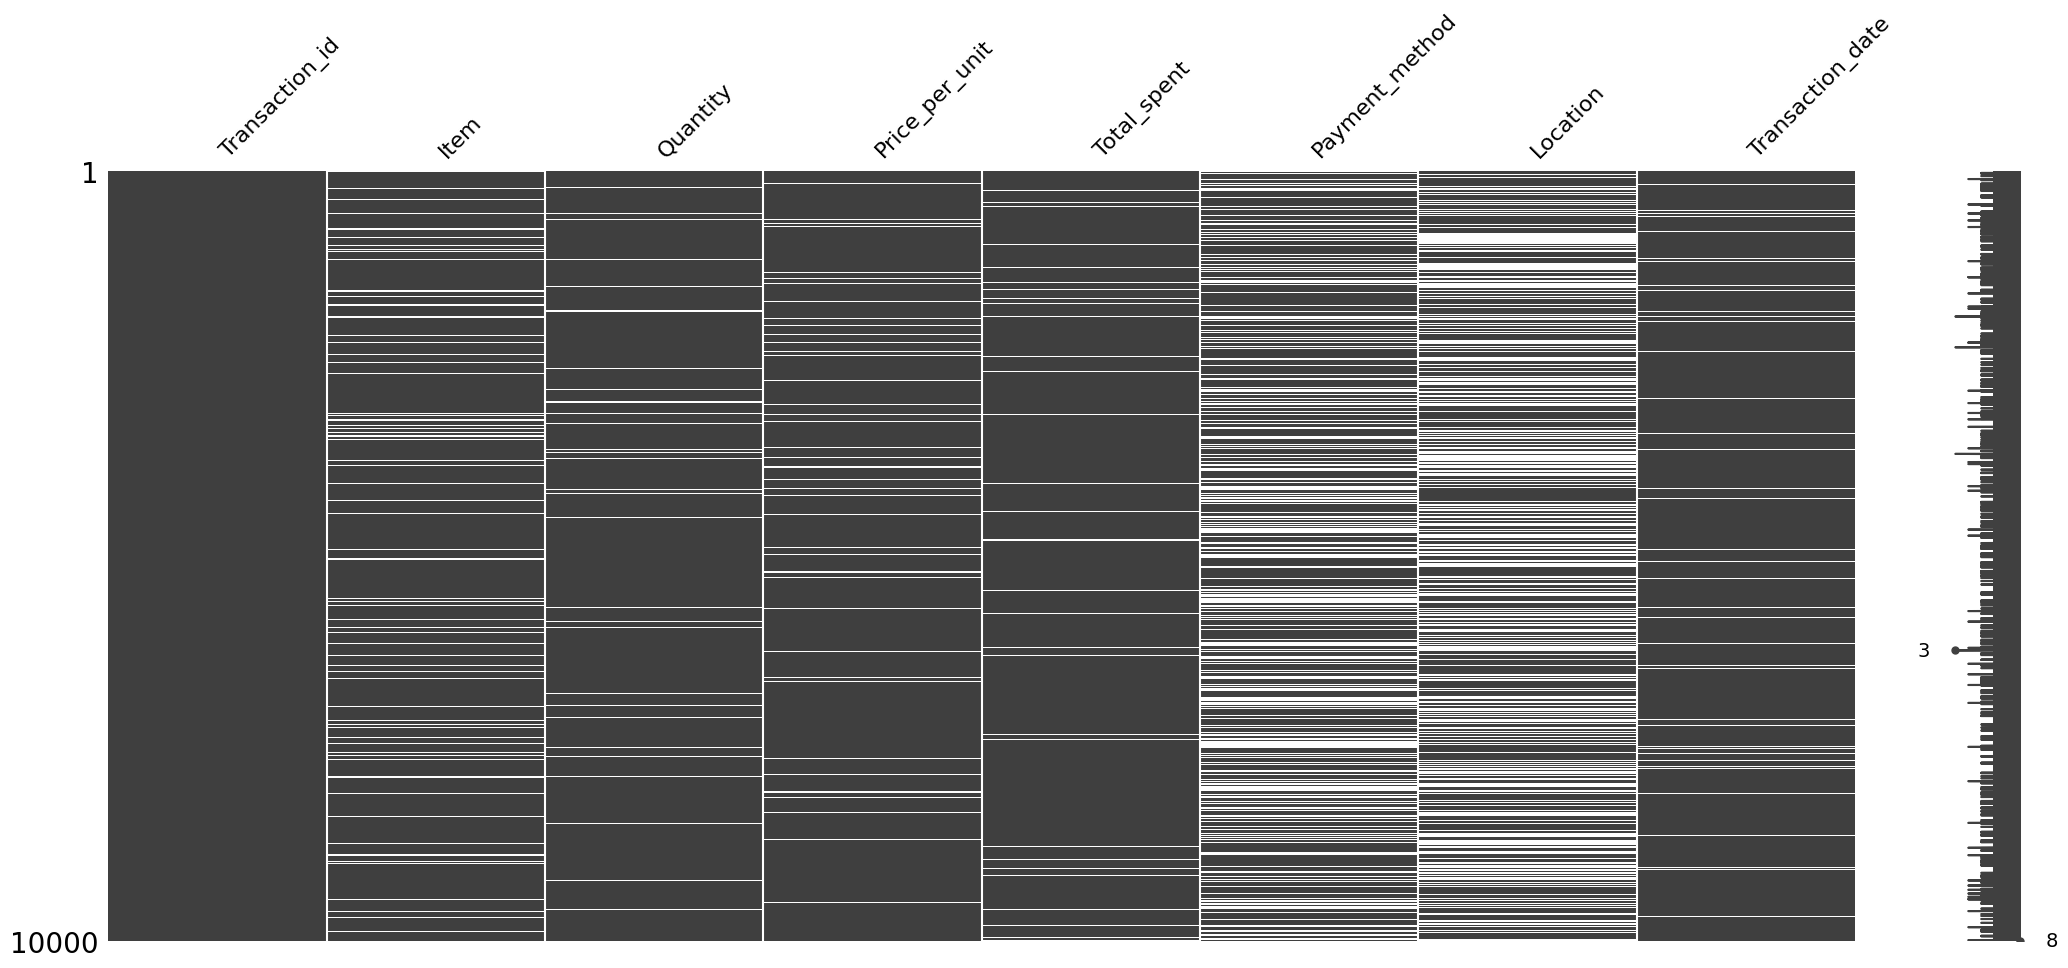

In [192]:
#Visualize the missing data
msno.matrix(df)

plt.show()

The graph shows how our data is missing — every white space represent missing data.

It seems payment method and Location have a lot of missing values. Let's deal with them.


---



In [193]:
# Fill missing values in categorical columns with mode
df['Location'] = df['Location'].fillna(df['Location'].mode()[0])

df['Payment_method'] = df['Payment_method'].fillna(df['Payment_method'].mode()[0])
df['Item'] = df['Item'].fillna(df['Item'].mode()[0])

In [194]:
# Select where price is null and quantity and Total spent are not null
fill_price = df['Price_per_unit'].isna()& df['Total_spent'].notna()& df['Quantity'].notna()

# fill missing values in price column by diving total spent with Quantity
df.loc[fill_price, 'Price_per_unit'] = df.loc[fill_price, 'Total_spent'] / df.loc[fill_price, 'Quantity']

In [195]:
# Create dict of unique items and their prices
price_item_reverse = {
    2.0: 'Coffee',
    1.0: 'Cookie',
    3.0: 'Juice',
    5.0: 'Salad',
    4.0: 'Sandwich',
    1.5: 'Tea'
}

# Fill missng data in Item with corresponding price from dictionery
df['Item'] = df['Item'].fillna(df['Item'].map(price_item_reverse))

In [196]:
# create threshold of 10% to drop
threshold = 0.1

# drop rows in columns where nul values are below the threshold
columns_to_drop = df.columns[df.isnull().mean() < threshold].tolist()
df.dropna(subset=columns_to_drop, inplace=True)

In [197]:
df.isna().sum()

,0
Transaction_id,0
Item,0
Quantity,0
Price_per_unit,0
Total_spent,0
Payment_method,0
Location,0
Transaction_date,0


We have dealt with missing data and other anomalies.  
Now we can go the next level of Exploratory Analysis.

---



#Explatory Data Analysis

In [198]:
# Get statistical understnding of data.
df.describe()

,Quantity,Price_per_unit,Total_spent,Transaction_date
count,8630.000000,8630.000000,8630.000000,8630
mean,3.023870,2.947972,8.924450,2023-07-02 10:48:55.063731200
min,1.000000,1.000000,1.000000,2023-01-01 00:00:00
25%,2.000000,2.000000,4.000000,2023-04-01 00:00:00
50%,3.000000,3.000000,8.000000,2023-07-03 00:00:00
75%,4.000000,4.000000,12.000000,2023-10-02 00:00:00
max,5.000000,5.000000,25.000000,2023-12-31 00:00:00
std,1.419084,1.278183,6.001765,NaN


In [199]:
# check data shape.
df.shape

(8630, 8)

Sales made during the Period.

In [200]:
# Revenue
df['Total_spent'].sum()

np.float64(77018.0)

In [201]:
# Sales by Items
Item_sales = df.groupby('Item')['Total_spent'].sum().sort_values(ascending=False)

# Top five by sales
Item_sales.head(5)

,Total_spent
Item,
Juice,16464.0
Salad,15085.0
Sandwich,11616.0
Smoothie,11604.0
Cake,8988.0


In [202]:
# Bottom Item by sales
Item_sales.tail(4)

,Total_spent
Item,
Cake,8988.0
Coffee,6218.0
Tea,4251.0
Cookie,2792.0


Datetime Analysis

In [203]:
# Extract periods
df['Year']  = df['Transaction_date'].dt.year
df['Month'] = df['Transaction_date'].dt.strftime('%B')
df['Day']   = df['Transaction_date'].dt.day
df['Hour']  = df['Transaction_date'].dt.hour

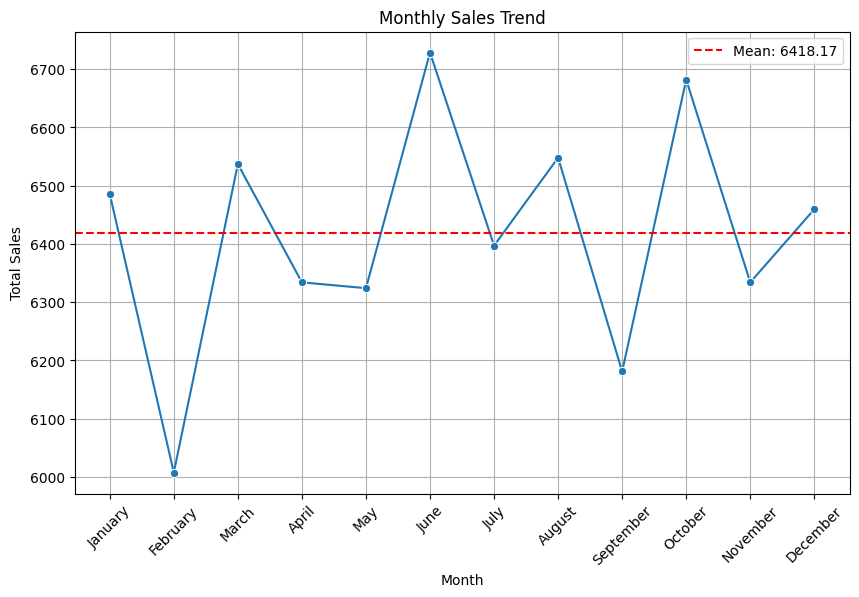

In [204]:
# sales by month
monthly_sales = df.groupby('Month')['Total_spent'].sum()

#Calculate the mean of monthly sales
mean_monthly_sales = monthly_sales.mean()

# sort the months numerically
monthly_sales = monthly_sales.sort_index(key=lambda x: pd.to_datetime(x, format='%B'))
plt.figure(figsize=(10, 6))
# Now plot
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.ylabel('Total Sales')
plt.grid(True)
plt.axhline(y=mean_monthly_sales, color='r', linestyle='--', label=f'Mean: {mean_monthly_sales:.2f}')
plt.legend()
plt.show()

Data shows that month of February we experienced very  the low sales compared to mean — dotted line coloured red.

Again graph shows month of January, March, June, August, October and December are only months we sold above average.

June is the month we made a lot of sales by making over $6700

---



##Distribution

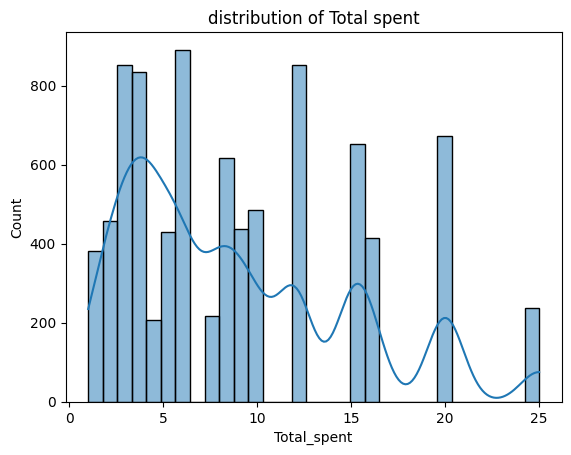

In [205]:
sns.histplot(data=df, x='Total_spent', kde = True)
plt.title('distribution of Total spent')
plt.show()

The bars in graph above shows how many times different spending amount occurred.  
The smooth blue curve line(KDE) shows smooth version of distribution. Y-axis shows the frequency.

Most bars are bunched to the left from 1 - 10 and few bars beyond 15 and 20. This distribution is *right skewed*.

This means most customers spend small amounts of money and few spend significantly more.

---



##Box Plot

/tmp/ipython-input-206-1464245430.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=df, kind='box', x='Item', y='Total_spent', palette='rainbow')


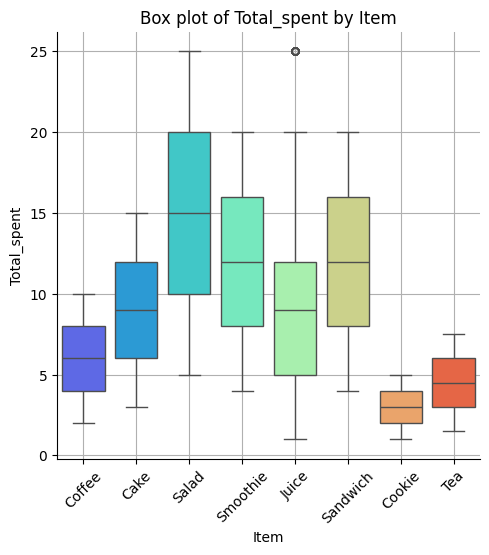

In [206]:
sns.catplot(data=df, kind='box', x='Item', y='Total_spent', palette='rainbow')
plt.xticks(rotation=45)
plt.title('Box plot of Total_spent by Item')
plt.grid(True)
plt.show()

Salad has high median of $15, wider variation in spent and long whiskers. It's top spender, customers spend differently.

Smoothie, Juice and Sandwich have median of around $12-15 and almost the same wide range. They attract diverse buyers. Outliers might indicate a toppings.

Cookie and Tea have low median as $ 3 or 4 and spread.

---



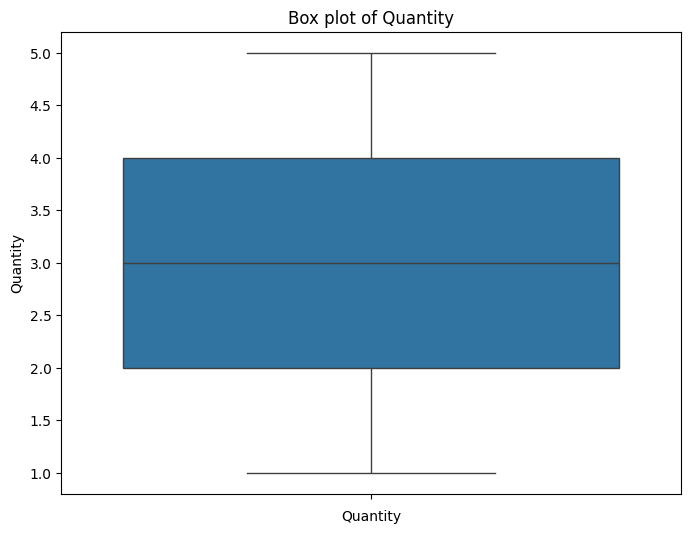

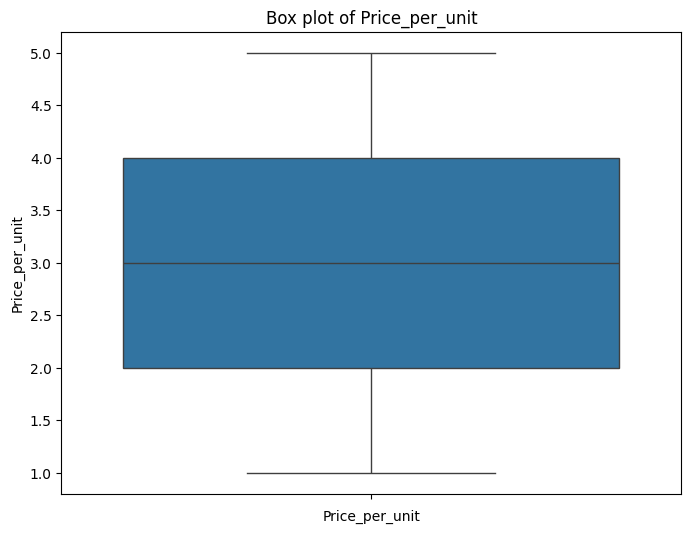

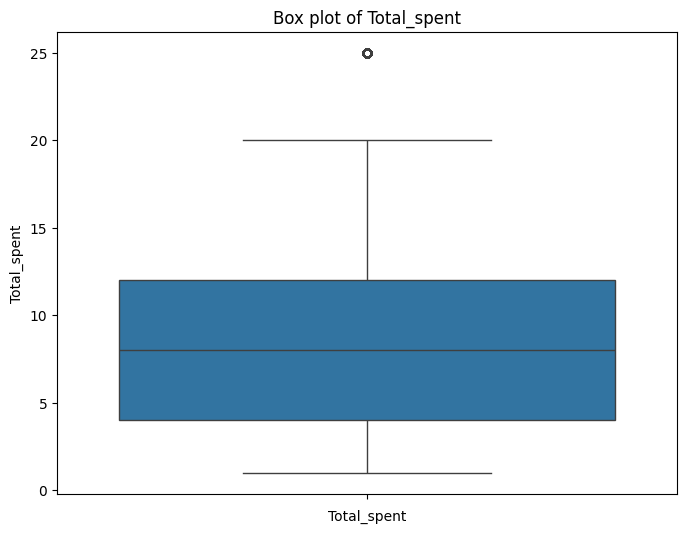

In [207]:
# Numerical variable distributions with box plots
numerical_cols = ['Quantity', 'Price_per_unit', 'Total_spent']

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col}')
    plt.xlabel(col)
    plt.show()

###Comapare weekday and weekend sales

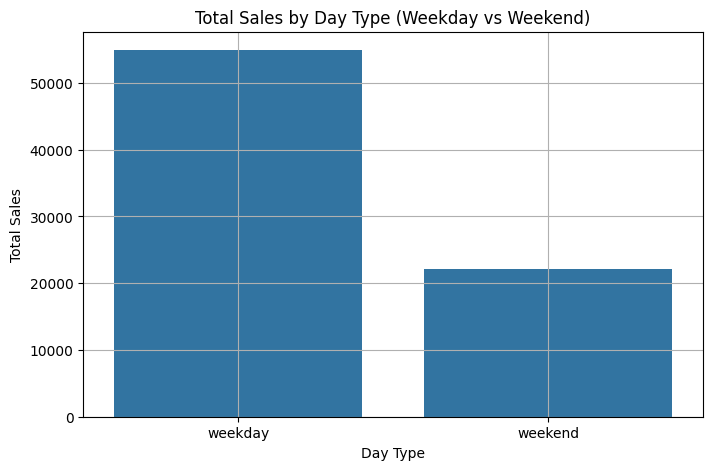

In [208]:
df['weekday'] = df['Transaction_date'].dt.dayofweek
df['Day_type'] = df['weekday'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')
sales_by_day_type = df.groupby('Day_type')['Total_spent'].sum().reset_index() # Convert Series to DataFrame

plt.figure(figsize=(8, 5))
sns.barplot(x='Day_type', y='Total_spent', data=sales_by_day_type)
plt.title('Total Sales by Day Type (Weekday vs Weekend)')
plt.xlabel('Day Type')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

We would expect Cafes to make more sales in weekends than during normal days of the week but that is not the case.

---



###Comparing Item sales in weekend and weekdays

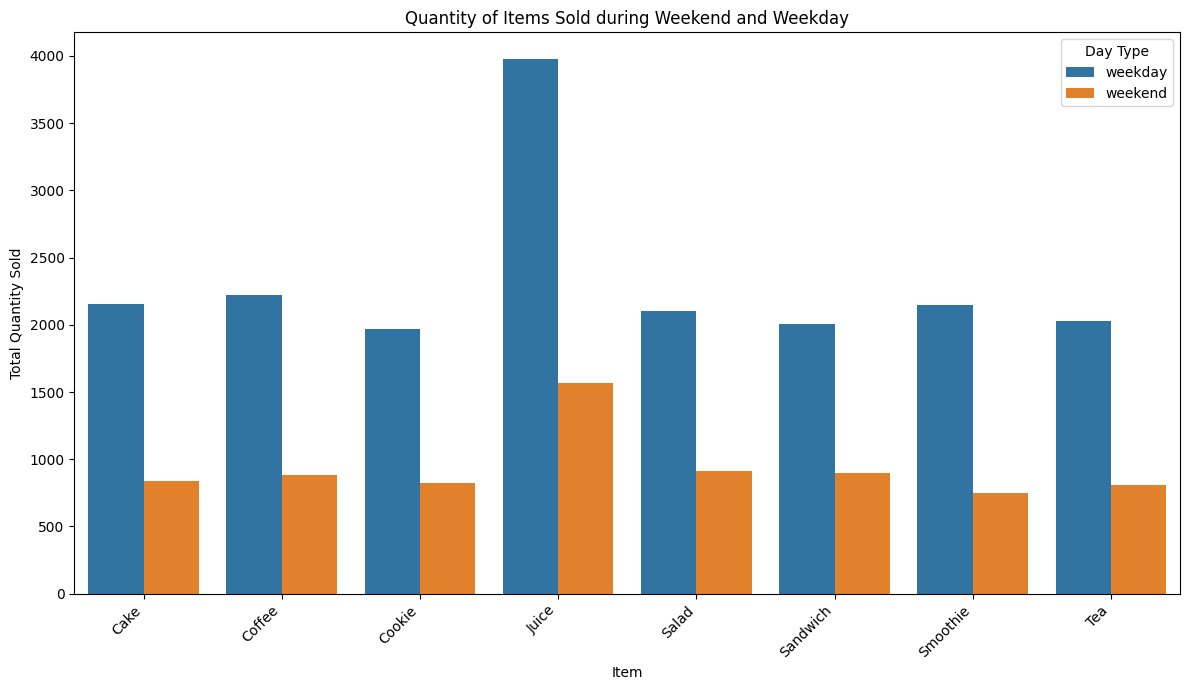

In [209]:
# Group by Day_type and Item and calculate the sum of Quantity
item_sales_by_day_type = df.groupby(['Day_type', 'Item'])['Quantity'].sum().reset_index()

# Create a bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=item_sales_by_day_type, x='Item', y='Quantity', hue='Day_type')
plt.title('Quantity of Items Sold during Weekend and Weekday')
plt.xlabel('Item')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Day Type')
plt.tight_layout()
plt.show()

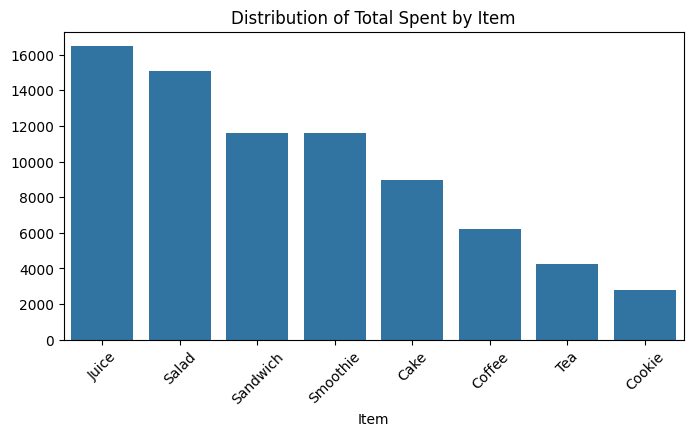

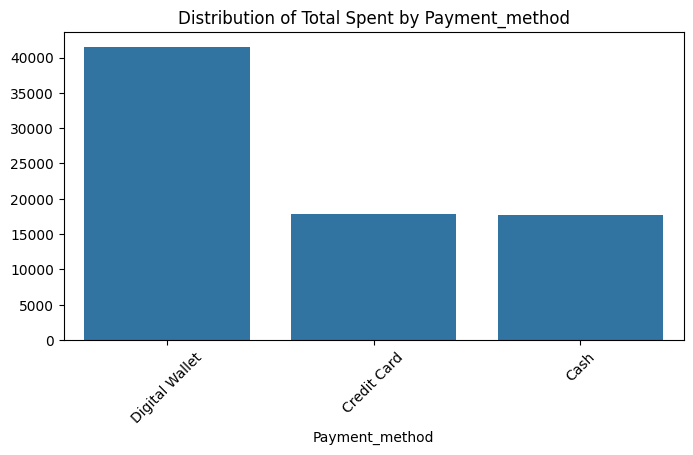

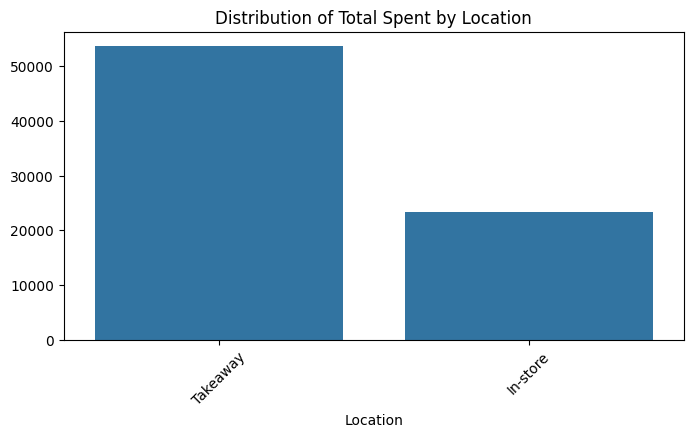

In [210]:
col_list = df.select_dtypes(include='object').columns.drop(['Transaction_id','Month', 'Day_type']).to_list()
for col in col_list:
    saes_by_cat = df.groupby(col)['Total_spent'].sum().sort_values(ascending=False)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=saes_by_cat.index, y=saes_by_cat.values)
    plt.title(f'Distribution of Total Spent by {col}')
    plt.xticks(rotation =45)
    plt.show()

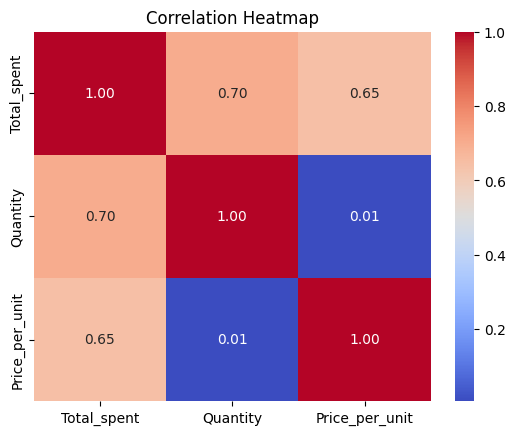

In [211]:
# correlation

numerical_df = df[['Total_spent', 'Quantity', 'Price_per_unit']] # Select only numerical columns
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt = '.2f')
plt.title('Correlation Heatmap')
plt.show()

According to above heatmap, there is no correlation between price and quantity.

Quantity spent have a correlation of 0.7

---



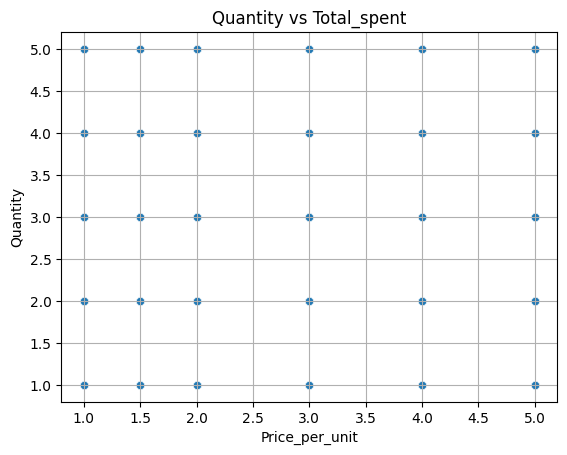

In [212]:
sns.scatterplot(data=df, y='Quantity', x='Price_per_unit')
plt.title('Quantity vs Total_spent')
plt.grid(True)
plt.show()

Price and quantity are evenly distributed. There is no correlation.

---



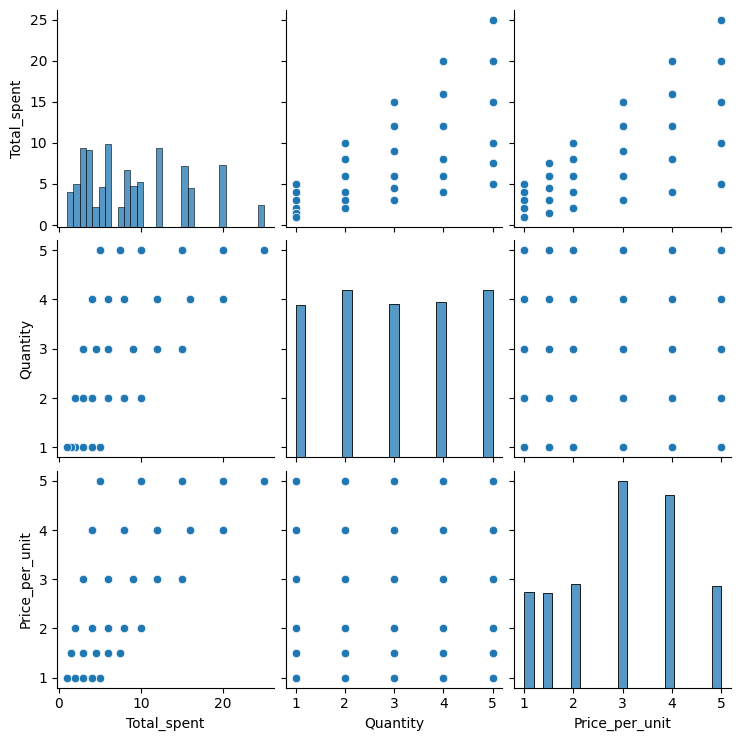

In [213]:
sns.pairplot(df[['Total_spent', 'Quantity', 'Price_per_unit']])
plt.show()